In [369]:
import numpy as np 
import pandas as pd 

In [370]:
students = pd.read_csv("students.csv")
exams = pd.read_csv("exams.csv")
enrolments = pd.read_csv("enrolements.csv")
rooms = pd.read_csv("rooms.csv")
slots= pd.read_csv("slots.csv")

In [371]:
class Exam:
    def __init__(self, exam_code, name, duration, department_code):
        self.code = exam_code
        self.name = name
        self.duration = duration
        self.dep_code = department_code
        self.conflicts = 0
        self.priority = 0
        self.slot = -1
        self.students = []
        self.room = 0
        self.roomAssigned = False

class Student:
    def __init__(self, student_code, course_code):
        self.code = student_code
        self.course_code = course_code
        self.exams = []
        self.exam_codes = []

class Enrolment:
    def __init__(self, student_code, exam_code):
        self.student_code = student_code
        self.exam_code = exam_code

class Room:
    def __init__(self, room_code, capacity):
        self.code = room_code
        self.capacity = capacity
        self.status = []
class Slot:
    def __init__(self, index, date, day, type):
        self.index = index
        self.date = date
        self.day = day
        self.type = type
        self.exams = []

In [372]:
examObjects = [Exam(**kwargs) for kwargs in exams.to_dict(orient='records')]

studentObjects = [Student(**kwargs) for kwargs in students.to_dict(orient='records')]

enrolmentObjects = [Enrolment(**kwargs) for kwargs in enrolments.to_dict(orient='records')]

roomObjects = [Room(**kwargs) for kwargs in rooms.to_dict(orient='records')]

slotObjects = [Slot(**kwargs) for kwargs in slots.to_dict(orient='records')]



In [373]:
for i in enrolmentObjects:
    for j in studentObjects:
        if j.code == i.student_code:
            j.exam_codes.append(i.exam_code)

In [374]:
for i in studentObjects:
    for j in examObjects:
        for k in i.exam_codes:
            if k == j.code:
                i.exams.append(j)
                j.students.append(i)

In [375]:
def hhToSeconds(s):
    t = 0
    splitTime = s.split(':')
    t = 60 * int(splitTime[0]) + int(splitTime[1])
    return t

In [376]:
for i in examObjects:
    i.duration = hhToSeconds(str(i.duration))

In [377]:
for i in roomObjects:
    for j in slotObjects:
        i.status.append(False)

In [378]:
def degreeOfConflict(exam):
    flagExam = enrolmentObjects[0]
    degree = 0
    for i in enrolmentObjects:
        if i.exam_code == exam.code:
            flagExam = i
            
    for j in enrolmentObjects:
        if j.exam_code != flagExam.exam_code and j.student_code == flagExam.student_code:
            degree += 1
    return degree

In [379]:
for i in examObjects:
    i.conflicts = degreeOfConflict(i)

In [380]:
def partialExamOrdering():
    sup = np.zeros(len(examObjects))
    for i in range(len(examObjects)):
        for j in range(len(examObjects)):
            if examObjects[i].conflicts > examObjects[j].conflicts:
                sup[i] = sup[i] + 1
                continue
            elif examObjects[i].conflicts < examObjects[j].conflicts:
                sup[j] = sup[j] + 1
                continue
            if len(examObjects[i].students) > len(examObjects[j].students):
                sup[i] = sup[i] + 1
                continue
            elif len(examObjects[i].students) < len(examObjects[j].students):
                sup[j] = sup[j] + 1
                continue
            if examObjects[i].duration > examObjects[j].duration:
                sup[i] = sup[i] + 1
                continue
            elif examObjects[i].duration < examObjects[j].duration:
                sup[j] = sup[j] + 1
                continue
            if examObjects[i].code > examObjects[j].code:
                sup[j] = sup[j] + 1
                continue
            elif examObjects[i].code < examObjects[j].code:
                sup[i] = sup[i] + 1
                continue
    return sup                               

In [381]:
def totalConflictsForExams():
    partialExamOrder = partialExamOrdering()
    for i in range(len(examObjects)):
        examObjects[i].priority = partialExamOrder[i]  

In [382]:
def getKey(obj):
    return obj.priority

In [383]:
EVAPORATION_RATE = 0.2
numAnts = 3
t_max = 5.0
t_min = 0.0019
MAX_ITER = 100
alpha = 1.0
beta = 4.0

In [384]:
pheromoneMatrix = []

def updatePheromoneMatrix():
    for i in range(len(examObjects)):
        for j in range(len(slotObjects)):
            if examObjects[i].slot == j:
                pheromoneMatrix[i][j] = (1 - EVAPORATION_RATE) * pheromoneMatrix[i][j] + 1
            else:
                pheromoneMatrix[i][j] = (1 - EVAPORATION_RATE) * pheromoneMatrix[i][j]
            if pheromoneMatrix[i][j] < t_min:
                pheromoneMatrix[i][j] = t_min
            elif pheromoneMatrix[i][j] > t_max:
                pheromoneMatrix[i][j] = t_max
    
def initPheromoneMatrix(exams, slots, value):
        for i in range(exams.size):
            pheromoneMatrix.append([value for j in range(len(slots))])
    

In [385]:
heuristicsMatrix = []

def initHeuristicsMatrix(exams, slots):
    for i in range(0, len(exams)):
        heuristicsMatrix.append([1 for j in range(len(slots))])

In [386]:
def getRoomKey(obj):
    return obj.capacity

In [387]:
def assignRooms(sortedExams):
    for i in sortedExams:
        for j in sorted(roomObjects, key=getRoomKey):
                if len(i.students) < j.capacity and j.status[i.slot.index-1] == False:
                    i.room = j
                    i.roomAssigned = True
                    j.status[i.slot.index-1] = True
            

In [388]:
def checkForHardConstraintViolations(exam, slot):
    score = 0
    for i in exam.students:
        for j in i.exams:
            if j.code != exam.code and j.slot != -1:
                if j.slot.index == slot.index:
                    score += 4
                if j.slot.index == 12:
                    score += 4
            if slot.index % 3 == 0 and exam.duration > 90:
                score += 4
    return score
                    

In [389]:
def checkForSoftConstraintViolations(exam, slot):
    score = 0
    for i in exam.students:
        for j in i.exams:
            if j.code != exam.code and j.slot != -1:
                if np.abs(j.slot.index - slot.index) < 4:
                    score += 1
    return score

In [390]:
def findForbiddenSlots(exam):
    forbiddenSlots = set()
    forbiddenSlots.add(slotObjects[11])
    for i in exam.students:
        for j in i.exams:
            if j.slot != -1 and j.code != exam.code:
                forbiddenSlots.add(j.slot)
    return forbiddenSlots

In [391]:
def numAdditionalViolations(exam, slot):
    score = 0
    score += checkForHardConstraintViolations(exam, slot)
    score += checkForSoftConstraintViolations(exam, slot)
    return score

In [392]:
def pheroHeuristicSummation(examIndex, slotIndex):
    sum = 0
    for j in range(len(slotObjects)):
        if j != slotIndex:
            sum = (pheromoneMatrix[examIndex][j]**alpha) * (heuristicsMatrix[examIndex][j]**beta)
    return sum

In [402]:
def chooseSlot(antIndex, examIndex, exam, slots):
    desirability = np.zeros(len(slotObjects))
    forbiddenSlots = list(findForbiddenSlots(exam))

    #availableSlots = set(slotObjects)
   # availableSlots = availableSlots - findForbiddenSlots(exam)
    #if exam.slot != -1:
    #    availableSlots = availableSlots - {exam.slot.index}
    for i in range(len(slotObjects)):
        for j in forbiddenSlots:
            if slotObjects[i].index == j.index:
                print("Desirability for " + str(slotObjects[i].index) + " is -1")
                desirability[i] = -1
                continue
            heuristicsMatrix[examIndex][i] = 1 / (1 + numAdditionalViolations(exam, slotObjects[i]))
            desirability[i] = ((pheromoneMatrix[examIndex][i]**alpha) * (heuristicsMatrix[examIndex][i]**beta))/pheroHeuristicSummation(examIndex, i)
    #print(exam.code + ": " + str(desirability) + ": " + str(slotObjects[np.argmax(desirability)]))
    return slotObjects[np.argmax(desirability)]

In [394]:
def evaluateHardConstraints():
    countHard = 0
    for i in studentObjects:
        for j in i.exams:
            for k in i.exams:
                if j.code != k.code and j.slot.index == k.slot.index:
                    countHard += 1
            if j.slot.index == 12:
                countHard += 1
            if j.slot.index % 3 == 0 and j.duration > 90:
                countHard += 1
    return countHard
                    

In [395]:
def evaluateSoftConstraints():
    countSoft = 0
    for i in studentObjects:
        for j in i.exams:
            for k in i.exams:
                if j.code != k.code and np.abs(j.slot.index - k.slot.index) < 4:
                    countSoft += 1
    return countSoft

In [396]:
def evaluate():
    metricHardConstraints = 0
    metricSoftConstraints = 0
    metricHardConstraints += evaluateHardConstraints()
    metricSoftConstraints += evaluateSoftConstraints()
    return metricSoftConstraints, metricHardConstraints

In [403]:
index = 0
initPheromoneMatrix(exams, slotObjects, t_max)
initHeuristicsMatrix(exams, slotObjects)
totalConflictsForExams()
sortedExamsByPriority = sorted(examObjects, key=getKey, reverse=True)
evaluationSoftMap = []
evaluationHardMap = []
while index < MAX_ITER:
    for k in range(numAnts):
        array = []
        chosenSlot = 0
        for i in range(len(examObjects)):
            #chosenSlot = chooseSlot(k, i,examObjects[i], slotObjects)
            #examObjects[i].slot = chosenSlot
            chosenSlot = chooseSlot(k, i,sortedExamsByPriority[i], slotObjects)
            sortedExamsByPriority[i].slot = chosenSlot
            #print(sortedExamsByPriority[i].code + ": " + str(sortedExamsByPriority[i].slot))
    assignRooms(sortedExamsByPriority)
    updatePheromoneMatrix()
    evaluationSoftMap.append((index, evaluate()[0]))
    evaluationHardMap.append((index, evaluate()[1]))
    #print("Iteration :" + str(index) + " complete.")
    index += 1

Desirability for 1 is -1
Desirability for 5 is -1
Desirability for 6 is -1
Desirability for 7 is -1
Desirability for 9 is -1
Desirability for 10 is -1
Desirability for 11 is -1
Desirability for 12 is -1
Desirability for 13 is -1
Desirability for 14 is -1
Desirability for 15 is -1
Desirability for 17 is -1
Desirability for 18 is -1
Desirability for 19 is -1
Desirability for 20 is -1
Desirability for 21 is -1
Desirability for 22 is -1
Desirability for 23 is -1
Desirability for 25 is -1
Desirability for 26 is -1
Desirability for 27 is -1
Desirability for 1 is -1
Desirability for 2 is -1
Desirability for 6 is -1
Desirability for 7 is -1
Desirability for 9 is -1
Desirability for 10 is -1
Desirability for 11 is -1
Desirability for 12 is -1
Desirability for 14 is -1
Desirability for 15 is -1
Desirability for 17 is -1
Desirability for 18 is -1
Desirability for 19 is -1
Desirability for 20 is -1
Desirability for 21 is -1
Desirability for 22 is -1
Desirability for 23 is -1
Desirability for 25 is

KeyboardInterrupt: 

In [1]:
evalHardDF = pd.DataFrame(evaluationHardMap, columns=['Iterations', 'Violations'])
evalHardDF.plot.line(x='Iterations', y='Violations')

NameError: name 'pd' is not defined

<AxesSubplot:xlabel='Iterations'>

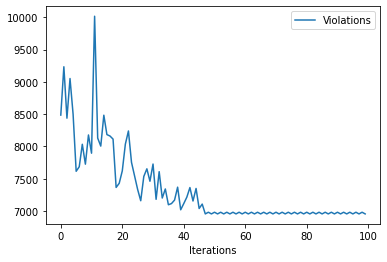

In [ ]:
evalSoftDF = pd.DataFrame(evaluationSoftMap, columns=['Iterations', 'Violations'])
evalSoftDF.plot.line(x='Iterations', y='Violations')

In [ ]:
examArr = []
for i in examObjects:
    if i.roomAssigned != False:
        examArr.append([i.code, i.slot.index, i.roomAssigned, i.room.code, i.duration, i.priority, i.conflicts, len(i.students), i.room.capacity, i.room.status])

In [ ]:
pd.DataFrame(examArr).to_csv('exam_output.csv')

In [ ]:
studentArr = []
for i in studentObjects:
    for j in i.exams:
        if j.roomAssigned != False:
            studentArr.append([i.code, j.code, j.slot.index, j.slot.day, j.slot.type, j.duration, len(j.students), j.room.capacity, j.room.status])

In [ ]:
pd.DataFrame(studentArr).to_csv('student_output.csv')